![image](https://github.com/Lexie88rus/NFL-1st-and-Future/raw/master/assets/image.jpg)

[Photo by Dave Adamson on Unsplash](https://unsplash.com/photos/-nATH0CrkMU)

# NFL Injury Analysis

It is amazing how data science can be applied to different areas of our life. Even in sports, data science can help to make the game safer for the athletes.

The main goal of this analysis is to find out factors, which lead to injury. In particular, find out if the effects that playing on synthetic turf versus natural turf can have on player movements and the factors that may contribute to lower extremity injuries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# image utils
from PIL import Image

# import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# import machine learning
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

/kaggle/input/nfl-playing-surface-analytics/PlayList.csv
/kaggle/input/nfl-playing-surface-analytics/InjuryRecord.csv
/kaggle/input/nfl-playing-surface-analytics/PlayerTrackData.csv
/kaggle/input/nfl-utils/inbox_1095143_81d15e8f085b6d72cd7f13fe6c173195_Screen Shot 2019-11-25 at 10.53.52 AM.png
/kaggle/input/nfl-utils/nfl_coordinates.png
/kaggle/input/nfl-utils/field.png
/kaggle/input/nfl-utils/motion_data.csv


Using TensorFlow backend.


## Load Data

Load the data as pandas dataframes:

In [2]:
play_df = pd.read_csv('../input/nfl-playing-surface-analytics/PlayList.csv')
player_df = pd.read_csv('../input/nfl-playing-surface-analytics/PlayerTrackData.csv')
injury_df = pd.read_csv('../input/nfl-playing-surface-analytics/InjuryRecord.csv')

## Data Exploration

First of all, I would like to perform the initial cleaning and make visualizations just to get familiar with the data and generate the ideas for the further analysis.

### Play Dataset Exploration

`1` General information:

In [3]:
unique_players = play_df.PlayerKey.nunique()
unique_games = play_df.GameID.nunique()
unique_plays = play_df.PlayKey.nunique()

print('There are {} players in the dataset.'.format(unique_players))
print('There are {} games in the dataset.'.format(unique_games))
print('There are {} plays in the dataset.'.format(unique_plays))

There are 250 players in the dataset.
There are 5712 games in the dataset.
There are 267005 plays in the dataset.


`2` Game exploration:

In [4]:
# create a dataframe with game-level information
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [5]:
# https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


def visualize_game_features(game_df, rotation = 90, add_labels = False, figsize=(10,10)):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 3, hspace=0.2, wspace=0.2)
    stadium_ax = fig.add_subplot(grid[0, :2])
    fieldtype_ax = fig.add_subplot(grid[0, 2])
    weather_ax = fig.add_subplot(grid[1, 0:])
    temperature_ax = fig.add_subplot(grid[2, 0:])
    temperature_box_ax = fig.add_subplot(grid[3, 0:])

    stadium_ax.bar(game_df.StadiumType.value_counts().keys(), game_df.StadiumType.value_counts().values, color='#00c2c7')
    stadium_ax.set_title('StadiumType')
    stadium_ax.set_xticklabels(game_df.StadiumType.value_counts().keys(), rotation=rotation)
    
    if add_labels:
        add_value_labels(stadium_ax, spacing=5)

    fieldtype_ax.bar(game_df.FieldType.value_counts().keys(), game_df.FieldType.value_counts().values, color=['#00c2c7', '#ff9e15'])
    fieldtype_ax.set_title('FieldType')
    fieldtype_ax.set_xticklabels(game_df.FieldType.value_counts().keys(), rotation=0)
    
    if add_labels:
        add_value_labels(fieldtype_ax, spacing=5)

    weather_ax.bar(game_df.Weather.value_counts().keys(), game_df.Weather.value_counts().values, color='#00c2c7')
    weather_ax.set_title('Weather')
    weather_ax.set_xticklabels(game_df.Weather.value_counts().keys(), rotation=rotation)
    
    if add_labels:
        add_value_labels(weather_ax, spacing=5)
        
    temperature_ax.hist(game_df.Temperature.astype(int).values, bins=30, range=(0,90))
    temperature_ax.set_xlim(0,110)
    temperature_ax.set_xticks(range(0,110,10))
    temperature_ax.set_xticklabels(range(0,110,10))
    temperature_ax.set_title('Temperature')
    
    temperature_box_ax.boxplot(game_df.Temperature.astype(int).values, vert=False)
    temperature_box_ax.set_xlim(0,110)
    temperature_box_ax.set_xticks(range(0,110,10))
    temperature_box_ax.set_xticklabels(range(0,110,10))
    temperature_box_ax.set_yticklabels(['Temperature'])

    plt.suptitle('Game-Level Exploration', fontsize=16)
    plt.show()

In [6]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']
    
    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']
    
    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']
    
    snow = ['Heavy lake effect snow']
    
    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']
        
    if row.Weather in cloudy:
        return 'Cloudy'
    
    if row.Weather in indoor:
        return 'Indoor'
    
    if row.Weather in clear:
        return 'Clear'
    
    if row.Weather in rainy:
        return 'Rain'
    
    if row.Weather in snow:
        return 'Snow'
      
    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan
    
    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(play_df):
    play_df_cleaned = play_df.copy()
    
    # clean StadiumType
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)
    
    # clean Weather
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)
    
    return play_df_cleaned

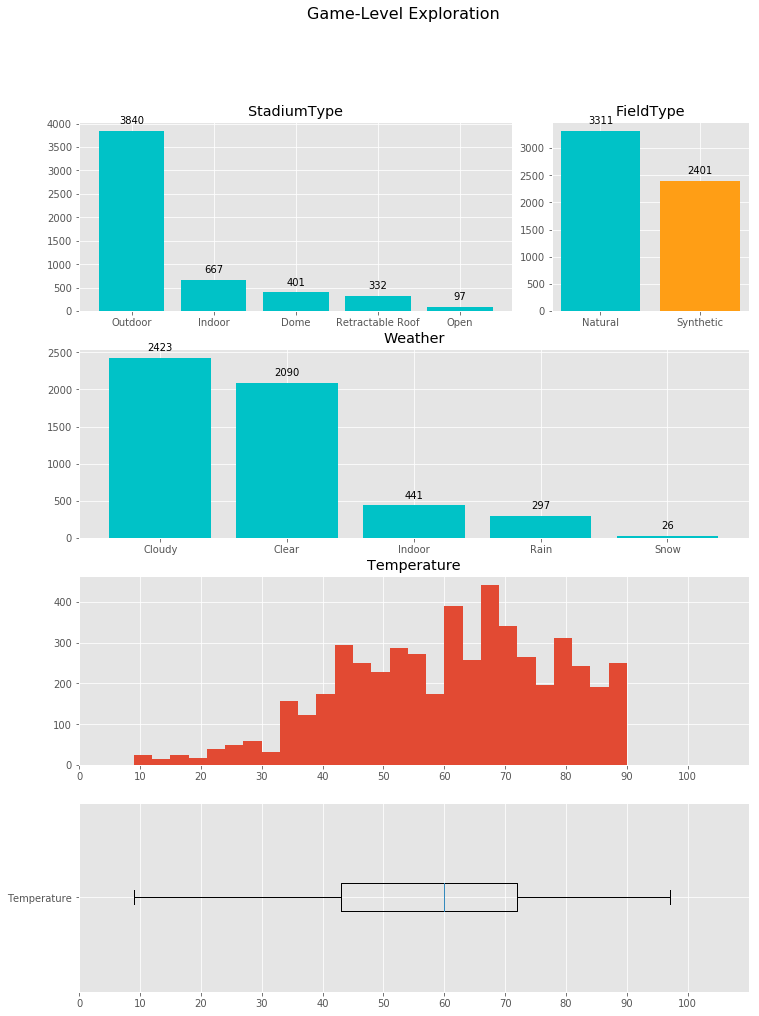

In [7]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])
visualize_game_features(game_df_cleaned, rotation=0, add_labels = True, figsize=(12,16))

The diagrams above show:

* __The majority of the games are played outdoors.__ That's why weather should be importsant.
* __Synthetic turf is very common, but there are around 30% more games with natural turf.__
* __The temperature and other weather conditions vary greately__. It will be interesting to look how the temperature affects the injuries.

`3` Player level exploration:

In [8]:
player_data_df = play_df_cleaned[['PlayerKey', 'RosterPosition', 'PlayerGamePlay', 'Position', 'PositionGroup']]

In [9]:
def visualize_player_features(player_df, figsize=(25,20), add_labels=False):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    
    grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)
    
    plays_ax = fig.add_subplot(grid[0, 0:2])
    max_rolling_plays_ax = fig.add_subplot(grid[1, 0:2])
    
    rosterposition_ax = fig.add_subplot(grid[0, 2:])
    positiongroup_ax = fig.add_subplot(grid[1, 2:])
    position_ax = fig.add_subplot(grid[2, 0:])
    
    plays_ax.hist(player_df.groupby(by=['PlayerKey']).count()['RosterPosition'].values, bins=20, color='#00c2c7')
    plays_ax.set_title('Number of plays per player')
    
    max_rolling_plays_ax.hist(player_df.groupby(by=['PlayerKey']).PlayerGamePlay.max().values, bins=20, color='#00c2c7')
    max_rolling_plays_ax.set_title('Maximum number of rolling plays per player')
    
    rosterposition_ax.bar(player_df.RosterPosition.value_counts().keys().values, player_df.RosterPosition.value_counts().values)
    rosterposition_ax.set_xticklabels(player_df.RosterPosition.value_counts().keys().values, rotation=20)
    rosterposition_ax.set_title('Roster Position')
    if add_labels:
        add_value_labels(rosterposition_ax, spacing=5)
    
    position_ax.bar(player_df.Position.value_counts().keys().values, player_df.Position.value_counts().values, color='#ff9e15')
    position_ax.set_title('Position')
    if add_labels:
        add_value_labels(position_ax, spacing=5)
        
    positiongroup_ax.bar(player_df.PositionGroup.value_counts().keys().values, player_df.PositionGroup.value_counts().values)
    positiongroup_ax.set_title('Position Group')
    if add_labels:
        add_value_labels(positiongroup_ax, spacing=5)
    
    plt.suptitle('Player-Level Exploration', fontsize=16)
    plt.show()

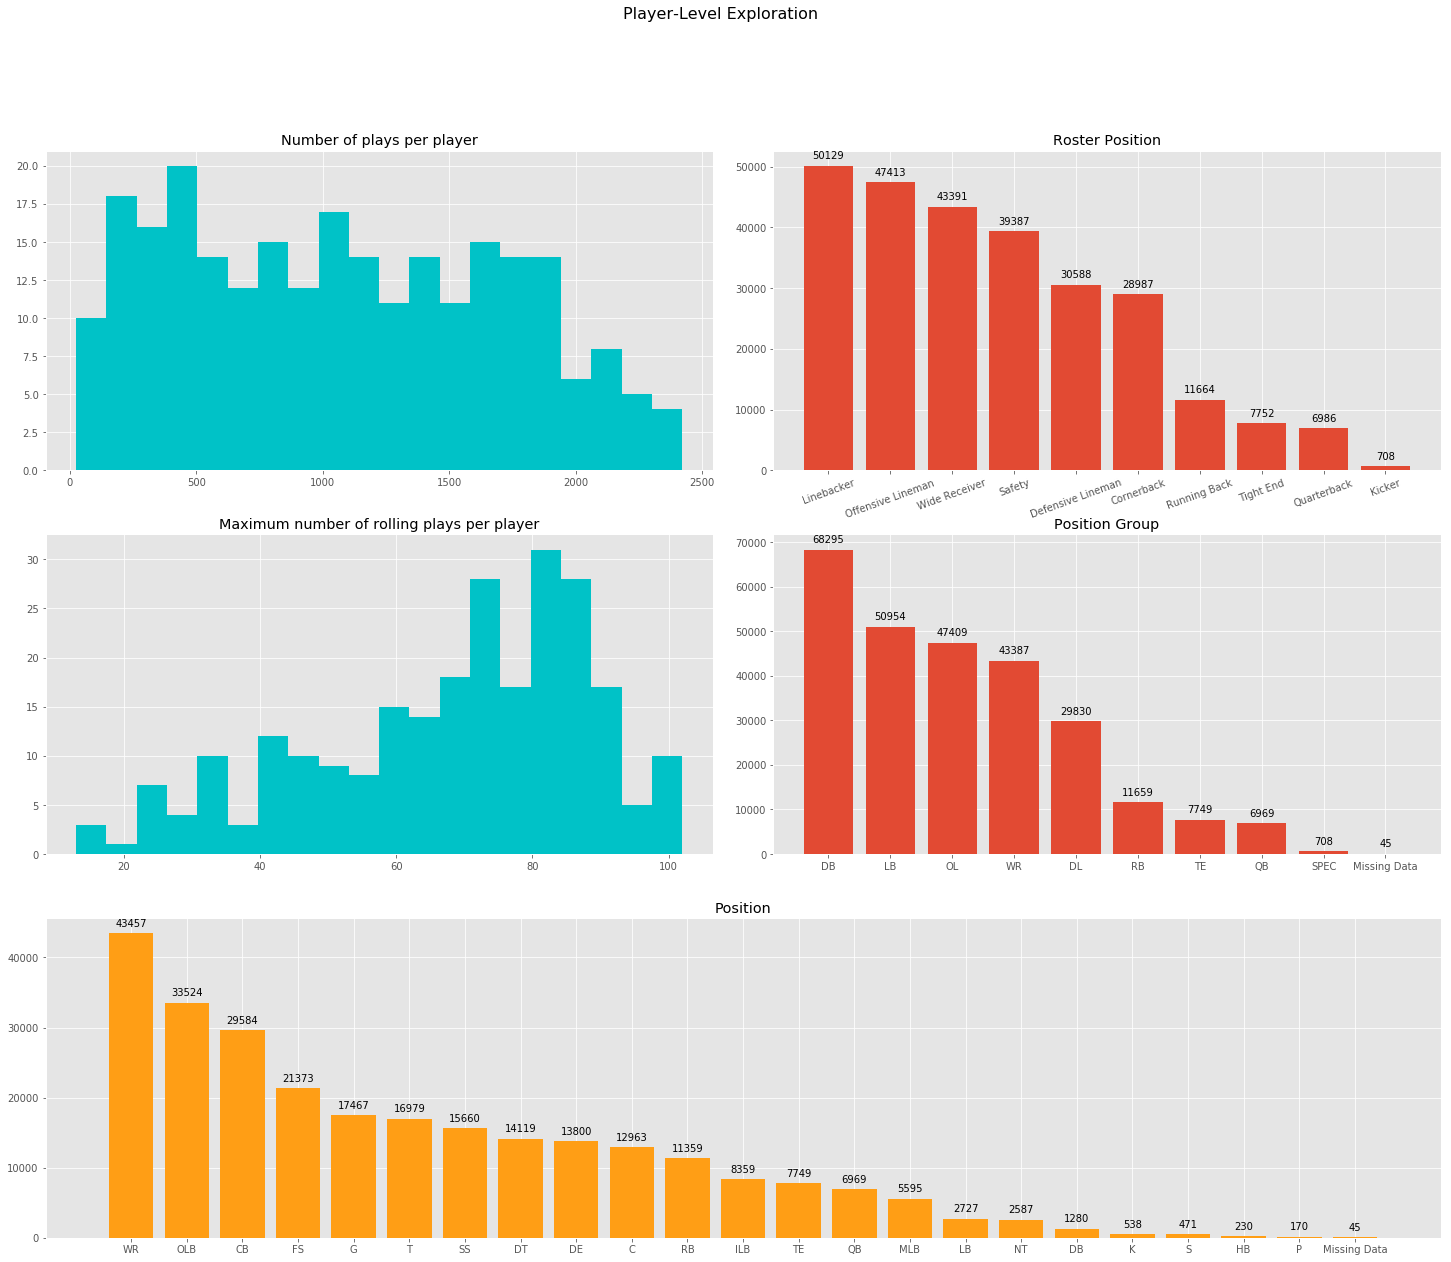

In [10]:
visualize_player_features(player_data_df, add_labels=True)

The diagrams above show that the circumstances around the players vary greately: some players do much more games than the others, there is a lot of different playing position. All these factors can contribute to injuries. 

`4` Play-level exploration:

In [11]:
def visualize_play(play_df_cleaned):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    
    plt.bar(play_df_cleaned.PlayType.value_counts().keys().values, play_df_cleaned.PlayType.value_counts().values)
    plt.xticks(range(len(play_df_cleaned.PlayType.value_counts().keys().values)), play_df_cleaned.PlayType.value_counts().keys().values, rotation=20)
    add_value_labels(ax, spacing=5)
    plt.title('Play-Level Exploration: PlayType', fontsize=16)
    
    plt.show()

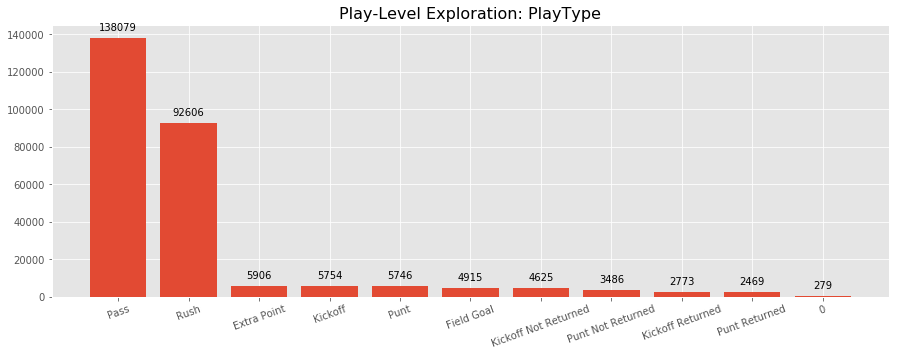

In [12]:
visualize_play(play_df_cleaned)

To my mind, it will be very interesting to see how play types affect the injury. I guess that some play types can cause much more dangerous situations than the others!

### Player Dataset Visualization and Exploration

`1` Visualize players positions and paths:

To my mind this is the most exciting part: we can take actual data and track the player's position!

Let's start with visualizing just one line of the dataset:

In [13]:
def get_position(player_df, playkey, time):
    '''
    Helper function to get the player position at a certain time
    '''
    row = player_df[(player_df['PlayKey']==playkey) & (player_df['time']==time)]
    event = row['event'].values[0]
    x = row['x'].values[0]
    y = row['y'].values[0]
    direction = row['dir'].values[0]
    distance = row['dis'].values[0]
    orientation = row['o'].values[0]
    speed = row['s'].values[0]
    
    return event, x, y, direction, distance, orientation, speed
    
def visualize_player_position(player_df, playkey, time, figsize=(24,10)):
    '''
    Helper function to visualize a single player position.
    '''
    
    event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)
    
    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    
    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')
    
    # show orientation
    dx = 5
    dy = dx*np.tan(np.radians(90 + orientation))
    plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
    plt.plot(x*10,y*10,color = '#767676', label='orientation')
    
    # show speed
    dx = speed*20
    dy = dx*np.tan(np.radians(90 + direction))
    plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
    plt.plot(x*10,y*10, color = '#004c97', label='speed')
    
    # show current player position
    plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
    plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')
    
    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))
    
    plt.title('{play}:{time} {event}'.format(play=playkey, time=time, event = event))
    
    plt.legend()
    plt.show()

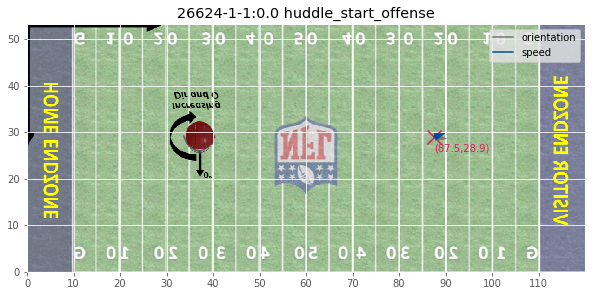

In [14]:
visualize_player_position(player_df, '26624-1-1', 0.0, figsize=(10,5))

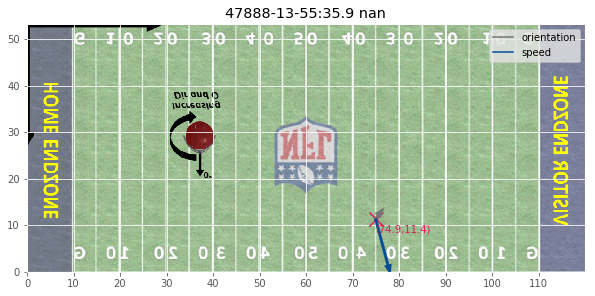

In [15]:
visualize_player_position(player_df, '47888-13-55', 35.9, figsize=(10,5))

We can also plot the entire path of the player during the play and see how he moved:

In [16]:
def visualize_player_track(player_df, playkey, figsize=(24,10), max_positions = 5):
    '''
    Helper function to visualize the whole path of the player
    '''
    # get timestamps per player
    timestamps = player_df[player_df['PlayKey'] == playkey].time.unique()
    
    background = Image.open('../input/nfl-utils/nfl_coordinates.png')
    background = background.resize((1200,533))
    
    # show background
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.array(background).transpose(0,1,2), origin='lower')
    
    # iterate through timestamps
    positions_x, positions_y = [], []
    for i in range(0, len(timestamps), len(timestamps) // max_positions):
        time = timestamps[i]
        # get position and orientation
        event, x, y, direction, distance, orientation, speed = get_position(player_df, playkey, time)
        positions_x.append(x*10)
        positions_y.append(y*10)
        
        # plot orientation and speed for the lasi point
        if (len(timestamps) - i < len(timestamps) // max_positions):
            # show orientation
            dx = 5
            dy = dx*np.tan(np.radians(90 + orientation))
            plt.arrow(x*10,y*10,dx,dy, color = '#767676', width=5)
            plt.plot(x*10,y*10,color = '#767676', label='orientation')

            # show speed
            dx = speed*20
            dy = dx*np.tan(np.radians(90 + direction))
            plt.arrow(x*10,y*10,dx,dy, color = '#004c97', width=5)
            plt.plot(x*10,y*10, color = '#004c97', label='speed')
            
            # add x-marker and annotation only for the last position
            plt.scatter(x*10,y*10,s=200,color='#e01e5a',marker='x')
            plt.annotate('({x:.1f},{y:.1f})'.format(x=x,y=y), (x*10, y*10), xytext=(x*10,y*10-30), color='#e01e5a')
        
    # show player's path
    plt.scatter(positions_x,positions_y,s=50,color='#e01e5a',marker='o')
    plt.plot(positions_x,positions_y,color='#e01e5a', label='player path', linestyle='--')
    
    # creat custom tick labels
    plt.xticks(range(0,1200,100), range(0,120,10))
    plt.yticks(range(0,533,100), range(0,53,10))
    
    # add title
    plt.title('{play}'.format(play=playkey))
    
    plt.legend()
    plt.show()

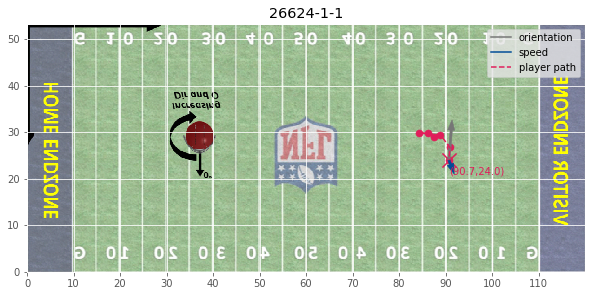

In [17]:
visualize_player_track(player_df, '26624-1-1', max_positions = 5, figsize=(10,5))

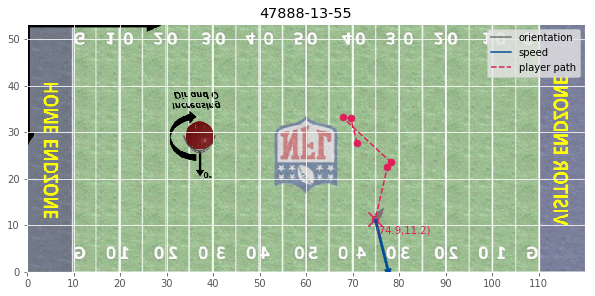

In [18]:
visualize_player_track(player_df, '47888-13-55', max_positions = 5, figsize=(10,5))

`2` Create a heatmap of the field

Let's look at the heatmap of the field:

In [19]:
def visualize_field_heatmap(player_df, xbins=13, ybins=6, annotate = False):
    # create a grid
    x = np.linspace(0, 120, xbins)
    y = np.linspace(0, 53, ybins)
    
    # initialize heatmap
    hmap = np.zeros((xbins,ybins))
    
    for i in range(xbins-1):
        for j in range(ybins-1):
            hmap[i,j] = len(player_df[(player_df.x >= x[i]) & (player_df.x <= x[i+1]) & (player_df.y >= y[j]) & (player_df.y <= y[j+1])])
            
    fig = plt.figure(figsize=(10,5))
    ax = sns.heatmap(np.transpose(hmap), annot=annotate, fmt = '.0f')
    plt.title('Field Heatmap \n the most visited areas of the field are highlighted')
    plt.show()

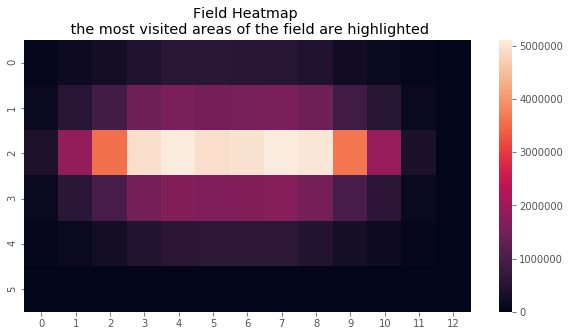

In [20]:
visualize_field_heatmap(player_df)

We can see that some areas of the field are more 'busy' than the others.

### Injuries Dataset EDA

Let's look quickly at the injuries:

In [21]:
print('There are {} injury records in total.'.format(len(injury_df)))

There are 105 injury records in total.


In [22]:
print('{} unique players injured'.format(len(injury_df.PlayerKey.unique())))

100 unique players injured


This means that there are players injured twice!

In [23]:
print('There are {} PlayKey values missing.'.format(len(injury_df) - injury_df.PlayKey.count()))

There are 28 PlayKey values missing.


For around 30% of the injuries we don't know the play, when the injury took place. It is quite a big number.

In [24]:
def visualize_injury(injury_df):
    injury_df_cleaned = injury_df.copy()
    injury_df_cleaned.DM_M1 = injury_df_cleaned.DM_M1 - injury_df_cleaned.DM_M7
    injury_df_cleaned.DM_M7 = injury_df_cleaned.DM_M7 - injury_df_cleaned.DM_M28
    injury_df_cleaned.DM_M28 = injury_df_cleaned.DM_M28 - injury_df_cleaned.DM_M42
    
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    
    axs[0].bar(injury_df_cleaned.BodyPart.value_counts().keys().values, injury_df_cleaned.BodyPart.value_counts().values, color='#00c2c7')
    axs[0].set_title('Body Part')
    add_value_labels(axs[0], spacing=5)
    
    axs[1].bar(injury_df_cleaned.Surface.value_counts().keys().values, injury_df_cleaned.Surface.value_counts().values, color='#ff9e15')
    axs[1].set_title('Surface')
    add_value_labels(axs[1], spacing=5)
    
    M1 = injury_df_cleaned.DM_M1.sum()
    M7 = injury_df_cleaned.DM_M7.sum()
    M28 = injury_df_cleaned.DM_M28.sum()
    M42 = injury_df_cleaned.DM_M42.sum()
    
    axs[2].bar(['1-7', '7-28', '28-42', '>=42'], [M1, M7, M28, M42])
    axs[2].set_title('Missed Days')
    add_value_labels(axs[2], spacing=5)
    
    plt.suptitle('Injury', fontsize=16)
    plt.show()

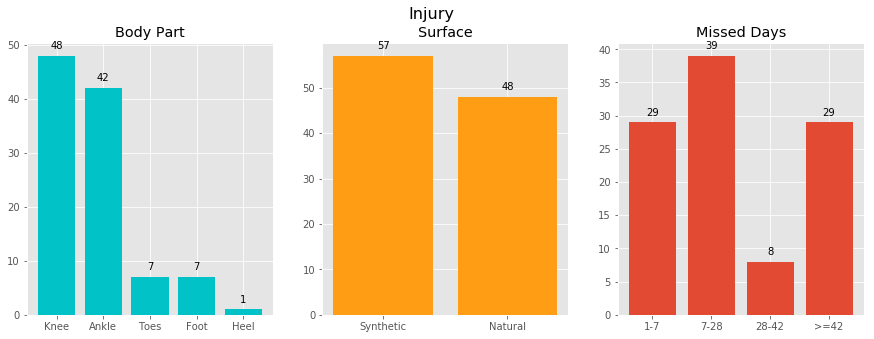

In [25]:
visualize_injury(injury_df)

All in all, we have just **105** injury records! So few!

* We can see that the __knees and ankles are the most frequently injured body parts.__
* We have almost __equal number of observations for synthetic and natural surface.__

## Injury Analysis

`1` Merge injury data with game data (drop the play-level information), so we can explore the dependencies between the injuries and game-level factors.

In [26]:
# joined cleaned games dataset and injury dataset
game_injury_df = injury_df.set_index('GameID').join(game_df_cleaned.set_index('GameID'), how = 'outer')

# fill null values for the injury columns with zeros
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# introduce a column with a flag indicating an injury
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# drop duplicated surface column
game_injury_df = game_injury_df.drop(columns=['Surface'])

# drop play-level features just for now
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# create dummy variables
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

`2` Now let's visualize the correlations:

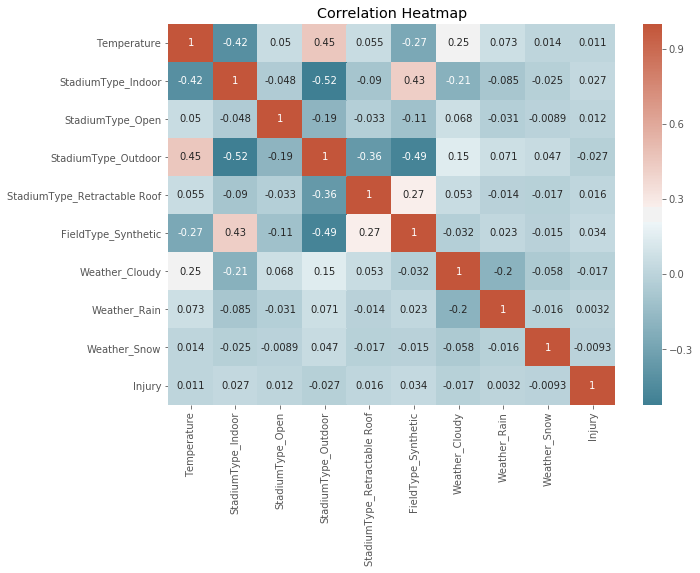

In [27]:
corr_df = game_injury_df_dummies[['Temperature', 'StadiumType_Indoor', 'StadiumType_Open', 'StadiumType_Outdoor', 'StadiumType_Retractable Roof',
                                 'FieldType_Synthetic', 'Weather_Cloudy', 'Weather_Rain', 'Weather_Snow', 'Injury']].corr()

fig = plt.figure(figsize=(10,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

Unfortunately, there is __no correlation between our features and the injury.__

Let's look at [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V):

In [28]:
# Source:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [29]:
# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(pd.crosstab(df[col1], df[col2]).as_matrix())
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Cramer V Correlation between Variables");

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


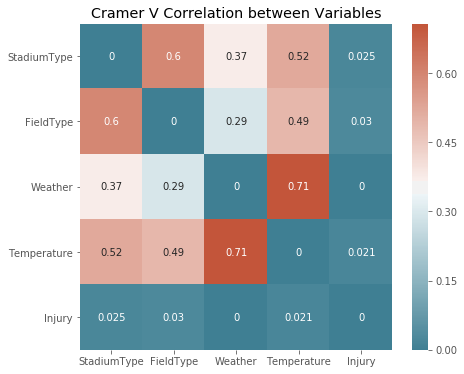

In [30]:
cols = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
plot_cramers_v_heatmap(game_injury_df, cols)

This table looks way more interesting!
* We can see that there are correlations between Weather and Temperature (obviously, snow and rain means lower temperature than sunny weather).
* There is also some correlation between Stadium Type and Temperature.

But unfortunately, still no correlation with the Injury.

Let's try [Theil’s U](https://docs.oracle.com/cd/E40248_01/epm.1112/cb_statistical/frameset.htm?ch07s02s03s04.html) to find some insights:

In [31]:
# Source:
# https://github.com/shakedzy/dython/blob/master/dython/nominal.py

from collections import Counter
import math

def conditional_entropy(x, y, nan_strategy='replace', nan_replace_value=0):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [32]:
def plot_theils_u_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = theils_u(df[col1].values, df[col2].values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Theil's U Correlation between Variables");

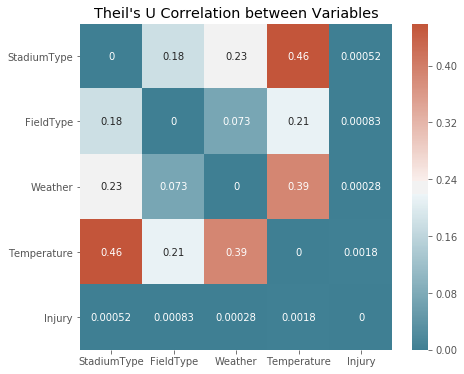

In [33]:
cols = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
plot_theils_u_heatmap(game_injury_df, cols)

Again, no insights on injury.

`3` Explore the game features with respect to the injury:

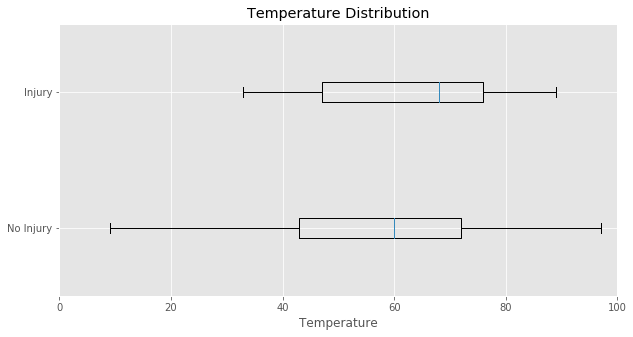

In [34]:
fig = plt.figure(figsize=(10,5))
plt.boxplot([game_injury_df[game_injury_df.Injury == 0].Temperature.values, game_injury_df[game_injury_df.Injury == 1].Temperature.values], vert = False)
plt.title('Temperature Distribution')
plt.yticks([1,2], ['No Injury', 'Injury'])
plt.xlim(0,100)
plt.xlabel('Temperature')
plt.show()

This diagram is not meaningful: we have just 105 injury observations, that is why temperature is not spanning so wide for the observations with injuries.

`4` Play-level features:

In [35]:
# joined cleaned games dataset and injury dataset
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(play_df_cleaned.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right')

# fill null values for the injury columns with zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop(columns=['Surface'])

# create dummy variables
play_injury_df_dummies = pd.get_dummies(play_injury_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

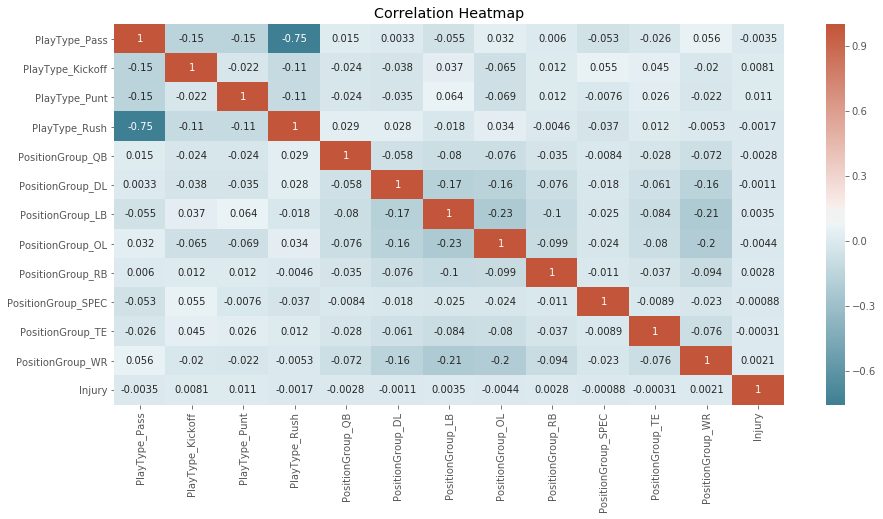

In [36]:
corr_df = play_injury_df_dummies[['PlayType_Pass', 'PlayType_Kickoff', 'PlayType_Punt', 'PlayType_Rush',
                                  'PositionGroup_QB', 'PositionGroup_DL', 'PositionGroup_LB', 'PositionGroup_OL',
                                  'PositionGroup_RB', 'PositionGroup_SPEC', 'PositionGroup_TE', 'PositionGroup_WR',
                                  'Injury']].corr()

fig = plt.figure(figsize=(15,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

Cramer's V:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


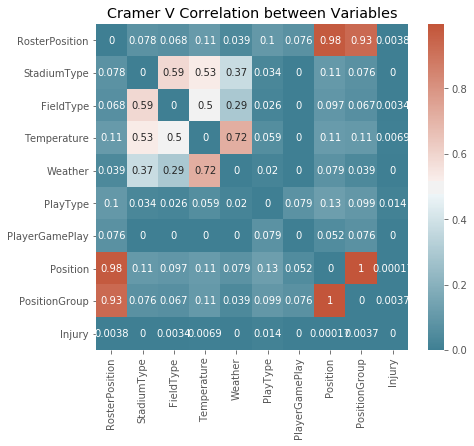

In [37]:
cols = ["RosterPosition", "StadiumType", "FieldType", "Temperature", "Weather", 'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup', 'Injury']
plot_cramers_v_heatmap(play_injury_df, cols)

Again, this chart shows us some obvious correlations, but still nothing is correlated with the injury.

Let's tru Theil's U:

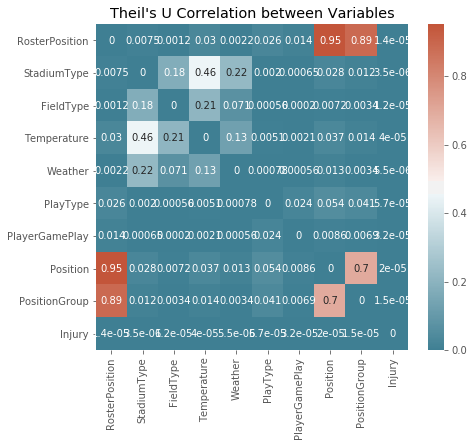

In [38]:
plot_theils_u_heatmap(play_injury_df, cols)

Unfortunately, there are no insights on injury.

Visualize the heatmap of the field with the plays with the injury:

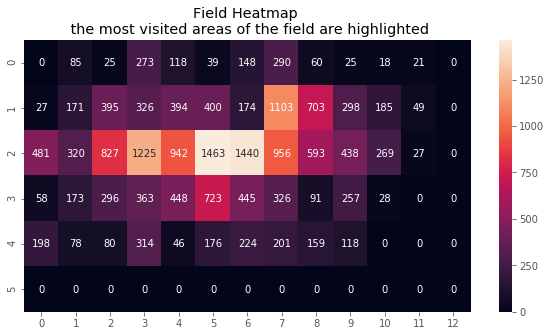

In [39]:
# find the keys of the plays related to injuries
play_injuries = play_injury_df.reset_index().dropna()[['PlayKey']]
# merge the playkeys associated with injuries with players' positions
player_injuries = player_df.merge(play_injuries, on='PlayKey', how='inner') # use inner join!
# visualize the heatmap
visualize_field_heatmap(player_injuries, annotate = True)

It looks like the heatmap of injuries is somewhat different from the general heatmap of the field! This may mean that there are more dangerous areas on the field, where players are more likely to get injured!

We can use this insight for the feature engineering for the injury prediction model!

## Game Timeline and Injury Analysis

Let's plot a timeline of player's games and highlight the days with injuries:

In [40]:
def player_games_timeline(player_key, play_df, injury_df):
    '''
    Function to plot the player's timeline
    '''
    player_games = play_df[play_df.PlayerKey == player_key][['GameID', 'PlayKey', 'PlayerDay', 'PlayerGame']]
    
    # plot timeline for the player
    plt.figure(figsize=(20,5))
    plt.title('Player Games Timeline \n PlayerKey: ' + str(player_key))  
    plt.plot(player_games.PlayerDay.unique(), np.zeros(len(player_games.PlayerDay.unique())), color='#00c2c7')
    plt.scatter(player_games.PlayerDay.unique(), np.zeros(len(player_games.PlayerDay.unique())), s=100, color='#00c2c7', label='games')
    
    # add games with injury
    injured_players = injury_df.PlayerKey.unique()
    if player_key in injured_players:
        injury_games = injury_df[injury_df.PlayerKey == player_key].GameID.values
        injury_days = player_games[player_games.GameID.isin(injury_games)].PlayerDay.unique()
        
        plt.scatter(injury_days, np.zeros(len(injury_days)), s=100, color='#e01e5a', label='injury')
    
    plt.legend()
    plt.xlabel('days')
    plt.yticks([])
    plt.show()

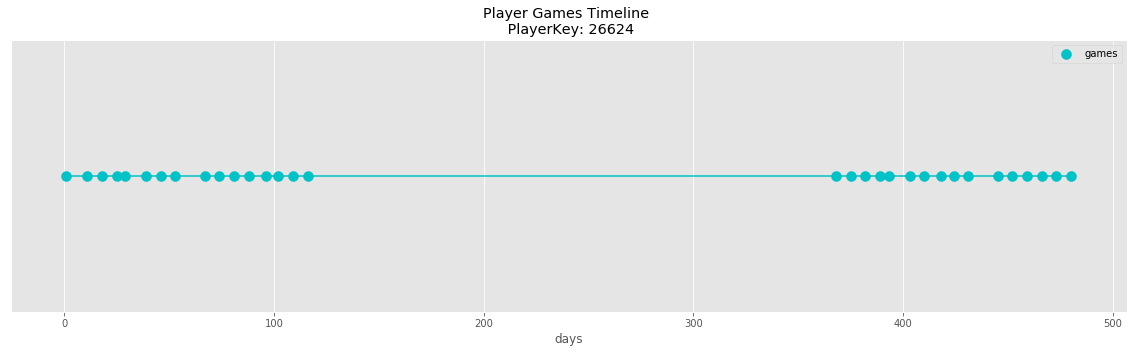

In [41]:
player_games_timeline(26624, play_df, injury_df)

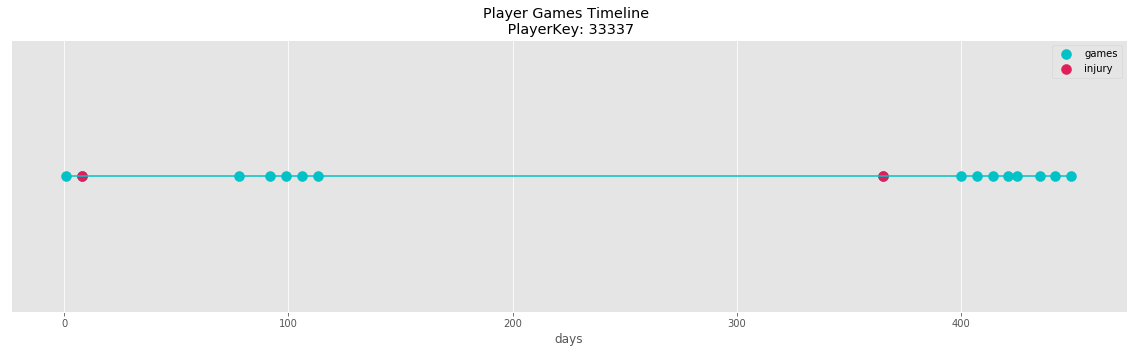

In [42]:
player_games_timeline(33337, play_df, injury_df)

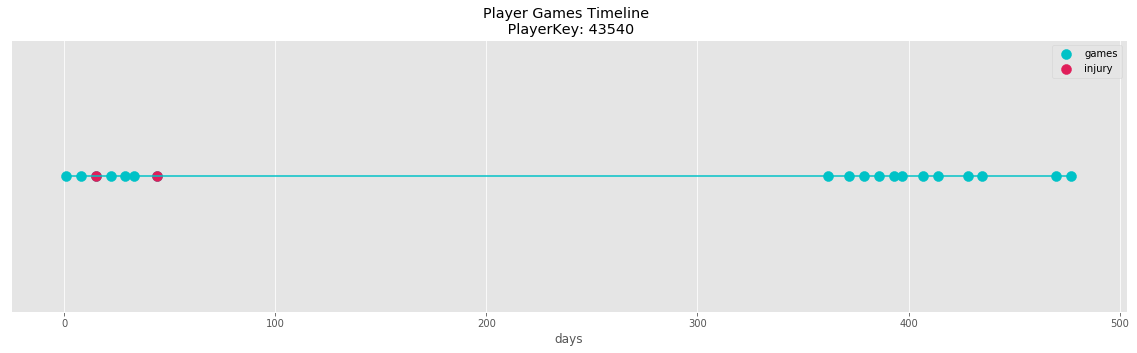

In [43]:
player_games_timeline(43540, play_df, injury_df)

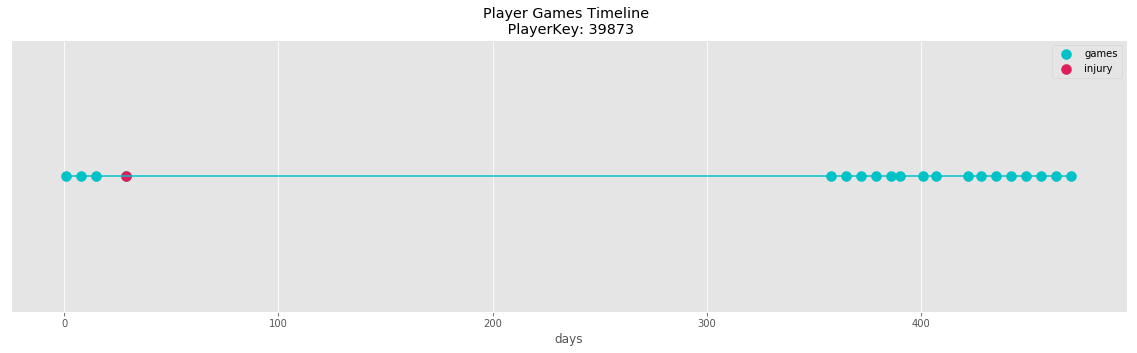

In [44]:
player_games_timeline(39873, play_df, injury_df)

I picked some random injured players from the dataset. It seems that injuries happen in the beginning of the season (for each individual player). This might be another interesting thing to check.

So is the speed of the player, his position on the field and the number of the game (`PlayerGame`) correlated with the injury?

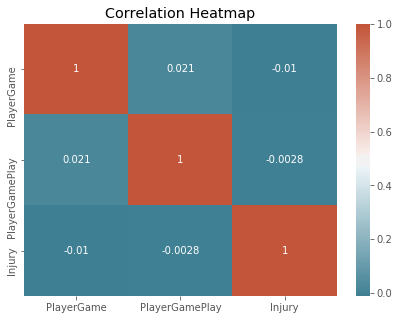

In [45]:
play_injury = play_injury_df[['PlayerGame', 'PlayerGamePlay', 'Injury']]
corrs = play_injury.corr()

fig = plt.figure(figsize=(7,5))
sns.heatmap(corrs, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

The diagram above shows that there is no correlation between the injury and the number of the games/plays per game played. I guess we might see such small correlation values because injuries themselves are extremely rare.

## Data Engineering

My next step is to try to extract features and try to build a model to predict the injury. Hopefully, I will be able to extract the feature importances out of this model and find out the injury drivers.

In [46]:
# reset index 
features_df = play_injury_df.copy().reset_index()
# drop the irrelevant columns
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# convert into dummies
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

## Machine Learning

We have the prepared data, now we can move to the machine learning part.

`1` Split into features and targets:

In [47]:
# split into X and y
y = features_df['Injury']
X = features_df.drop(columns=['Injury'])

`2` Use stratified split to split into train and test set so that class labels will be evenly distributed among the train and the test set:

In [48]:
skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.values[train_index, :], X.values[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

`3` Resampling the dataset:

The number of plays with injury is so tiny, that we can't just use the data as is. Our model will just always predict no injury. That is why we need to resample our dataset. Resampling will help us to generate more examples of cases from the rare class (the injury), so we can train our model! I will use [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) library.

In [49]:
res = RandomOverSampler(random_state=0)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)

`4` Training the model:

In [50]:
model = xgb.XGBClassifier(max_depth=3,
                      learning_rate=0.1,
                      n_estimators=100,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=42)
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=50,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='auto', verbosity=1)

`5` Evaluate the model:

In [51]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)

print('Accuracy: {}'.format(accuracy))
print('Cohen kappa: {}'.format(cohen_kappa))
print('Confusion Matrix: \n {}'.format(conf_matrix))

Accuracy: 0.9032523857320489
Cohen kappa: 0.0002061452587444057
Confusion Matrix: 
 [[120581  12883]
 [    33      5]]


The model's performance is quite poor, but we can still look at the feature importances:

In [52]:
# extract the feature importances from XGBoost model
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame(feature_importances, index = X.columns).reset_index().rename(columns={'index':'feature', 0:'importance'}).sort_values(by=['importance'], ascending=False)

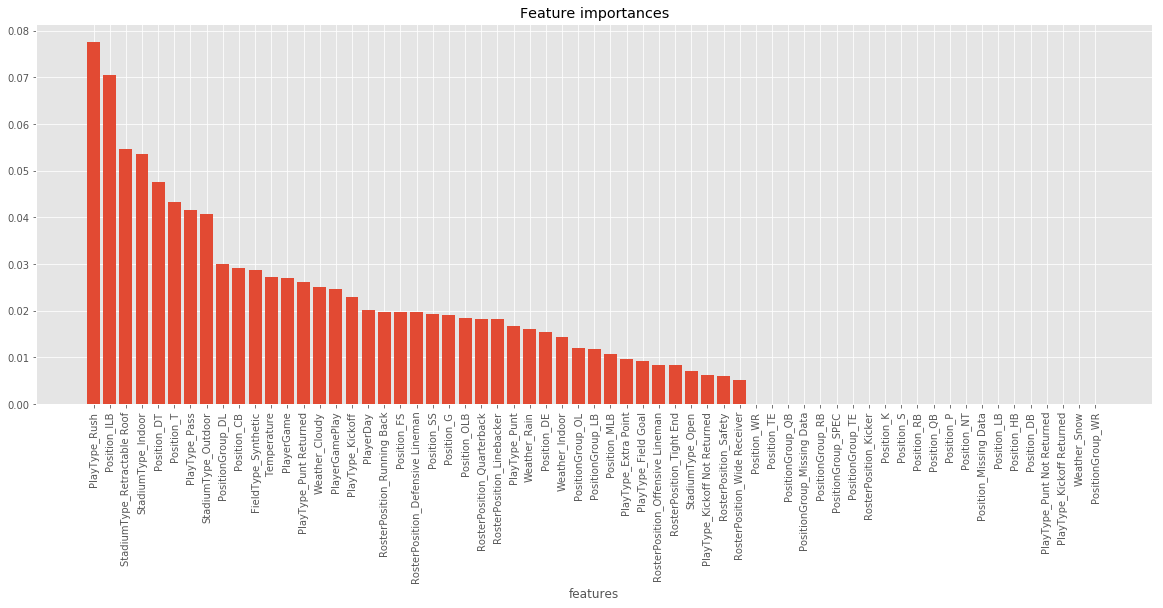

In [53]:
# plot as a bar chart
plt.figure(figsize=(20,7))
plt.bar(range(len(feature_importances)), feature_importances.importance.values)
plt.xticks(range(len(feature_importances)), feature_importances.feature.values, rotation=90)

plt.title('Feature importances')
plt.xlabel('features')
plt.show()

Looking at the chart above we can say:
* Weather and stadium type are possibly important factors impacting injury;
* Field type feature is not among the important features in our injury predicting model;
* __Player day and player game are actually important!__ This alignes with our observations of the players' timelines above! 

## Motion Data Analysis

One of the most interesting things in this competition is the analysis of player movements. We can extract a lot of different features for each play, for example:
* the average speed per play (might be calculated out of the coordinates or just the average per play);
* the sharpest turn per play;
* the average angle between the direction and the orientation;
* the maximum angle between the direction and the orientation.

The dataset is too big to process on Kaggle, so I will just include my preprocessing code here (see `create_motion_data_df`) and upload the result in the dataset.

In [54]:
def create_motion_data_df(injury_df, play_df, player_df):
    '''
    Function to create aggregated values for motion data.
    '''
    # create a field with the angle between direction and orientation
    player_df['angle'] = player_df['o'] - player_df['dir']
    
    # greate grouped dataframes
    grouped_max = player_df[['PlayKey','time', 'dir', 'dis', 'o', 's', 'speed', 'angle']].groupby(by=['PlayKey']).max()
    grouped_average = player_df[['PlayKey','time', 'dir', 'dis', 'o', 's', 'speed', 'angle']].groupby(by=['PlayKey']).mean()
    
    # merge with play data
    play_df = play_df.merge(grouped_max.reset_index(), on=['PlayKey'])
    play_df = play_df.merge(grouped_average.reset_index(), on=['PlayKey'], suffixes=('_max', '_avg'))
    
    # merge with injury data
    injury_df = injury_df.drop(columns=['PlayerKey', 'GameID', 'BodyPart', 'Surface']).merge(play_df, on=['PlayKey'], how='outer').fillna(0)
    
    return injury_df

In [55]:
# load the preprocessed data
motion_df = pd.read_csv('../input/nfl-utils/motion_data.csv').drop(columns=['Unnamed: 0'])
motion_df.head()

,PlayKey,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey,GameID,RosterPosition,PlayerDay,PlayerGame,...,dis_max,o_max,s_max,angle_max,time_avg,dir_avg,dis_avg,o_avg,s_avg,angle_avg
0,39873-4-32,1.0,1.0,1.0,1.0,39873.0,39873-4,Linebacker,29.0,4.0,...,0.93,359.47,8.98,329.63,22.05,189.061222,0.160837,126.987421,1.489140,-62.073801
1,46074-7-26,1.0,1.0,0.0,0.0,46074.0,46074-7,Linebacker,50.0,7.0,...,0.74,359.26,7.26,280.23,11.10,144.081300,0.210269,146.973453,2.024215,2.892152
2,36557-1-70,1.0,1.0,1.0,1.0,36557.0,36557-1,Safety,1.0,1.0,...,0.64,359.84,5.75,286.47,7.95,156.608562,0.168875,87.116313,1.574938,-69.492250
3,46646-3-30,1.0,0.0,0.0,0.0,46646.0,46646-3,Linebacker,15.0,3.0,...,0.76,359.67,7.23,304.71,12.45,126.469440,0.237160,188.707200,2.194320,62.237760
4,43532-5-69,1.0,1.0,1.0,1.0,43532.0,43532-5,Wide Receiver,32.0,5.0,...,0.57,359.98,4.73,331.65,17.45,164.235943,0.087743,160.628057,0.760543,-3.607886


In [56]:
# introduce a column with a flag indicating an injury
motion_df.DM_M1 = motion_df.DM_M1 - motion_df.DM_M7
motion_df.DM_M7 = motion_df.DM_M7 - motion_df.DM_M28
motion_df.DM_M28 = motion_df.DM_M28 - motion_df.DM_M42
motion_df['Injury'] = motion_df['DM_M1'] + motion_df['DM_M7'] + motion_df['DM_M28']+ motion_df['DM_M42']

Explore the correlations:

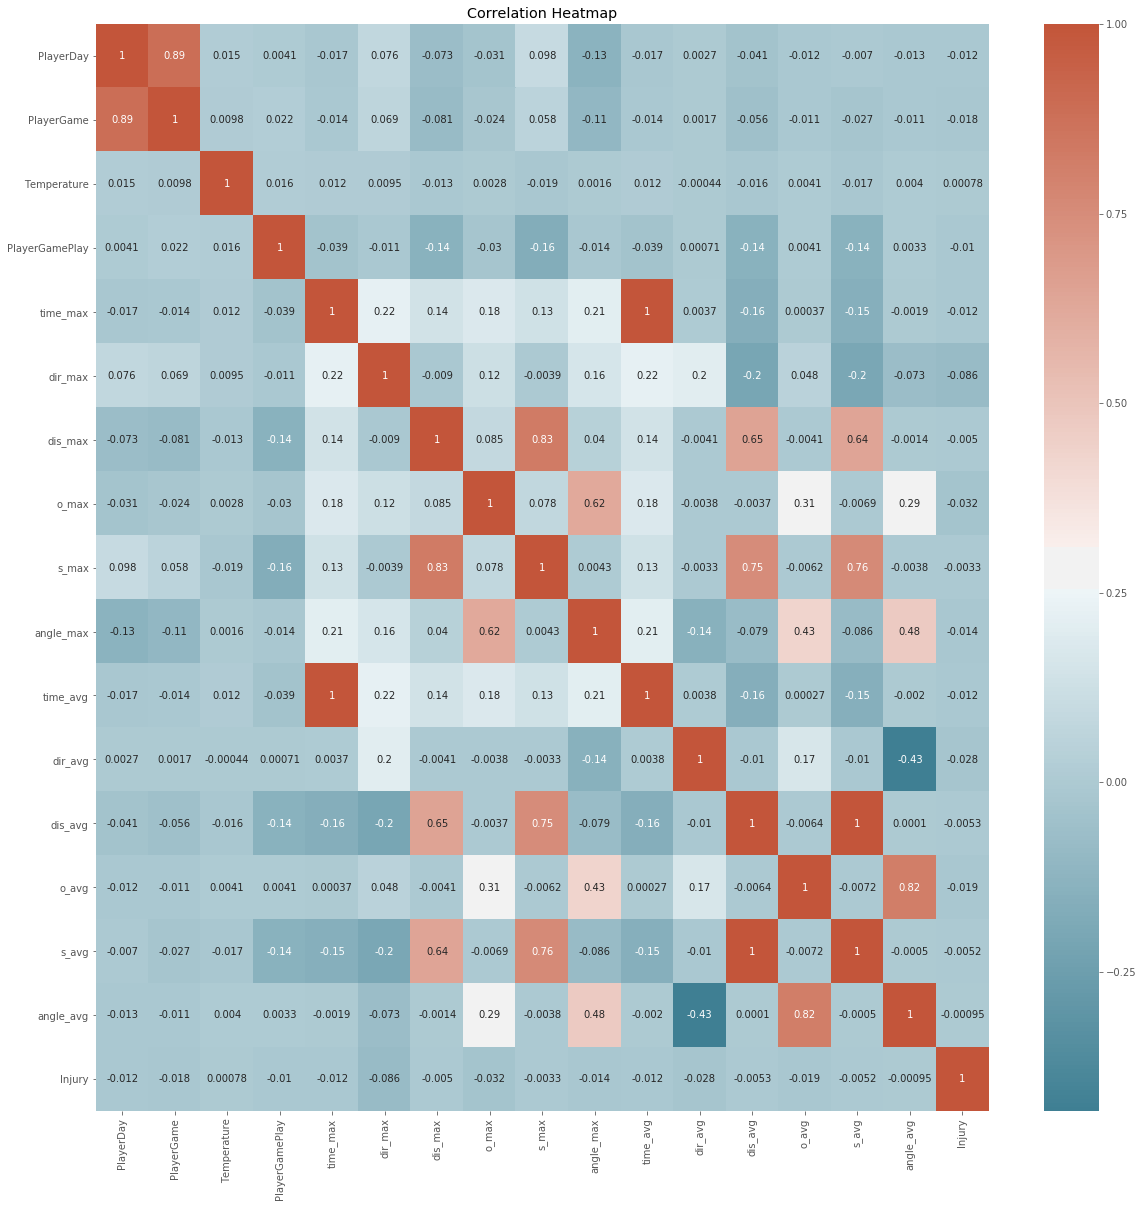

In [57]:
corr_df = motion_df[['RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType',
       'Temperature', 'Weather', 'PlayType', 'PlayerGamePlay', 'Position',
       'PositionGroup', 'time_max', 'dir_max', 'dis_max', 'o_max', 's_max',
       'angle_max', 'time_avg', 'dir_avg', 'dis_avg', 'o_avg', 's_avg',
       'angle_avg', 'Injury']].corr()

fig = plt.figure(figsize=(20,20))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

We can see that the distances and speed per play have negative correlation with PlayerGamePlay. Does it mean that players get tired and move slower?

There is a lot left to explore about motion! I will add that in the new versions of the analysis!

## Conclusions:
This is just the initial version of the analysis. This notebook contains:

* The initial cleaning of the free text columns (weather, stadium type);
* Data visualization, including visualization of positions of a player for each play and timeline of the games for a certain player;
* Correlations and dependencies of with the injury data (including various methods of exploring the correlation between categorical variables);
* A try to build a model for injury prediction and extraction of feature inportances out of the model.

## References and Credits
1. [Great Medium article](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) on correlation for categorical variables. I highly encourage to read it!
2. [dython library](https://github.com/shakedzy/dython/blob/master/dython/nominal.py): The implementation of Theil's U

__I will further update this notebook, so, please, feel free to ask questions and add comments!__